# Stock market prediction using Tensorflow

-Dataset from  Google finance API for S&P 500 comapanies- stockmarcket tick data

http://files.statworx.com/sp500.zip

The dataset contains n = 41266 minutes of data ranging from April to August 2017 on 500 stocks as well as the total S&P 500 index price

In [2]:
import pandas as pd

In [3]:
data = pd.read_csv("./sp500/data_stocks.csv")

Date variable is not useful for our analysis. So drop it !

In [4]:
data = data.drop("DATE",1)


Let's do some EDA

In [5]:
data.shape

(41266, 501)

In [6]:
data.isnull().sum()

SP500           0
NASDAQ.AAL      0
NASDAQ.AAPL     0
NASDAQ.ADBE     0
NASDAQ.ADI      0
NASDAQ.ADP      0
NASDAQ.ADSK     0
NASDAQ.AKAM     0
NASDAQ.ALXN     0
NASDAQ.AMAT     0
NASDAQ.AMD      0
NASDAQ.AMGN     0
NASDAQ.AMZN     0
NASDAQ.ATVI     0
NASDAQ.AVGO     0
NASDAQ.BBBY     0
NASDAQ.BIIB     0
NASDAQ.CA       0
NASDAQ.CBOE     0
NASDAQ.CELG     0
NASDAQ.CERN     0
NASDAQ.CHRW     0
NASDAQ.CHTR     0
NASDAQ.CINF     0
NASDAQ.CMCSA    0
NASDAQ.CME      0
NASDAQ.COST     0
NASDAQ.CSCO     0
NASDAQ.CSX      0
NASDAQ.CTAS     0
               ..
NYSE.USB        0
NYSE.UTX        0
NYSE.V          0
NYSE.VAR        0
NYSE.VFC        0
NYSE.VLO        0
NYSE.VMC        0
NYSE.VNO        0
NYSE.VTR        0
NYSE.VZ         0
NYSE.WAT        0
NYSE.WEC        0
NYSE.WFC        0
NYSE.WHR        0
NYSE.WM         0
NYSE.WMB        0
NYSE.WMT        0
NYSE.WRK        0
NYSE.WU         0
NYSE.WY         0
NYSE.WYN        0
NYSE.XEC        0
NYSE.XEL        0
NYSE.XL         0
NYSE.XOM  

No null values! all good.

In [7]:
from matplotlib import pyplot as plt
plt.plot(data['SP500'])
plt.xlabel("index")
plt.ylabel("time series data ")
plt.title ("S&P 500 time series index data")
plt.show()

<Figure size 640x480 with 1 Axes>

- Please keep in mind that the values you see are 1 minute shifter to future, already !
- This process is already done on the dataset and is necessory to do so inorder to predict the future market-status.
- Each row in the dataset contains the price of the S&P500 at t+1 and the constituent’s prices at T=t

######  train test split 80 -20

In [8]:
import  numpy as np
n = data.shape[0]
train_data_start = 0
train_data_ending = int(np.floor(0.8 * n))

test_data_start = train_data_ending
test_data_end = n

In [9]:
data_train = data.iloc[train_data_start : train_data_ending]
data_test = data.iloc[test_data_start : test_data_end]

scaling of input data is required to help the network to reach optimization faster and easier

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.fit_transform(data_test)

Make sure you scale train and test data seperately (as mentioned in above code)

In [11]:
# label column is SP500 - 0th column
X_train = data_train[:,1:]
X_test = data_test[:,1:]

Y_train = data_train[:,0]
Y_test = data_test[:,0]


#### Tensorflow 


As we are not using keras library, networks have to be build from scratch.


First, we define abstract representation of the model (neural network) through placeholders and variables.
Afterwards, the placeholders get "filled" with real data and the actual computations take place

###### This is a snippet of code to demostrate a basic TF graph (not part of the work)




In [12]:
# ----Code starts------
import tensorflow as tf
a = tf.placeholder(dtype=tf.int8)
b = tf.placeholder(dtype=tf.int8)

# define the functionality of a node
c = tf.add(a,b)

# initialize the graph
graph = tf.Session()

# execute the grapgh
graph.run(fetches=c,feed_dict={a:5,b:4})
#----Code Ends`----

9

In [13]:
X_train.shape[1]

500

Now, back to our networks:
- input X = stock prices of all S&P 500 constituents at time T = t
- output Y = the index value of the S&P 500 at time T = t + 1

> - input dimension : [None, n_stocks] and 
> - output dimension : [None]

None indicates the batch size 

In [14]:
import tensorflow as tf
n_stocks = X_train.shape[1]
X = tf.placeholder(dtype=tf.float32,shape=[None,n_stocks]) # n_stocks is 500
Y = tf.placeholder(dtype=tf.float32,shape=[None])

###### Model architecture



In [15]:
n_stocks = 500
n_neurons_1 = 1024
n_neurons_2 = 512
n_neurons_3 = 256
n_neurons_4 = 128  # Reduction in layer size means we compress the info
n_target = 1



######  initializers would give starting parameters for cost optimization process

In [16]:
# Support functions to initialize weights and bias

sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode="fan_avg",distribution="Uniform",scale=sigma) #in most cases, a unified initialization is sufficient
bias_initializer = tf.zeros_initializer()

In [17]:
#layer 1

W_hidden_1 = tf.Variable(weight_initializer([n_stocks,n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))

#layer 2

W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1,n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))

#layer 3

W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2,n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

#layer 4

W_hidden_4 = tf.Variable(weight_initializer([n_neurons_3,n_neurons_4]))
bias_hidden_4 = tf.Variable(bias_initializer([n_neurons_4]))

note the MxN and NxT dimensions of layers




The second dimension of the previous layer is the first dimension in the current layer for weight matrices

In [18]:
# Output layer

W_out = tf.Variable(weight_initializer([n_neurons_4,n_target]))
bias_out  = tf.Variable(bias_initializer([n_target]))

###### Next step is to combine
>placeholders (data) and variables (weighs and biases)


Hidden layers are transformed using activation function ReLU(Rectified Linear Unit)

In [30]:
# Hidden layers
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X,W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1,W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2,W_hidden_3), bias_hidden_3))
hidden_4 = tf.nn.relu(tf.add(tf.matmul(hidden_3,W_hidden_4), bias_hidden_4))

#Ouput Layer
# out = tf.nn.relu(tf.add(tf.matmul(hidden_4,W_out), bias_out)) Not giving better MSE after training
out = tf.transpose(tf.add(tf.matmul(hidden_4, W_out), bias_out))

###### Define Cost function
> MSE is the commonly used CF

> any differentiable function can be implemented in order to compute a deviation measure between predictions and targets

> MSE exhibits certain properties that are advantageous for the general optimization problem to be solved

In [31]:
# Cost Function

mse = tf.reduce_mean(tf.squared_difference(out, Y))

###### Define Optimizer 

> Helps to adapt the network’s weight and bias variables during training

In [32]:
opt = tf.train.AdamOptimizer().minimize(mse)

#### Train the network 

- data samples of n = batch_size are drawn from the training data and fed into the network

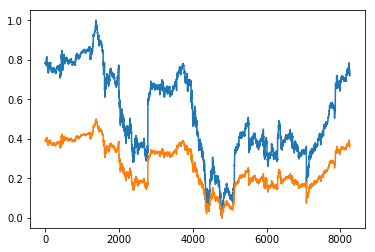

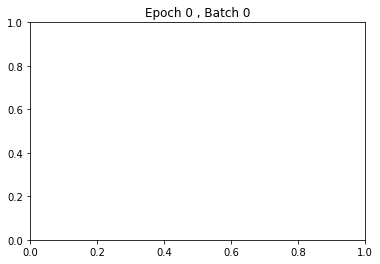

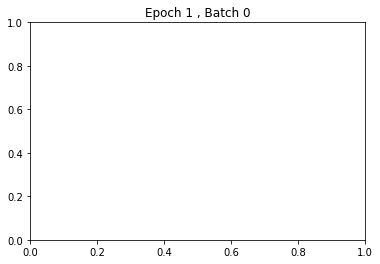

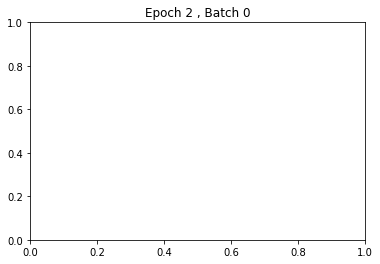

In [ ]:

# Define TF session
net = tf.InteractiveSession()
net.run(tf.global_variables_initializer())

plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1,= ax1.plot(Y_test)
line2,= ax1.plot(Y_test*0.5)
plt.show()

epochs = 10
batch_size = 256
mse_train = []
mse_test = []

# X = tf.placeholder(dtype=tf.float32,shape=[batch_size,n_stocks]) # n_stocks is 500
# Y = tf.placeholder(dtype=tf.float32,shape=[batch_size])

for e in range (epochs):
    # data shuffle
    shuffle_indices = np.random.permutation(np.arange(len(Y_test)))
    X_train = X_train[shuffle_indices]
    Y_train = Y_train[shuffle_indices]
    
    
    #batch training 
    for i in range(0, len(Y_train)//batch_size):
        start = i * batch_size
        batch_x = X_train[start:start + batch_size]
        batch_y = Y_train[start:start + batch_size]

        # Run the model
        net.run(fetches = opt ,feed_dict={X:batch_x,Y:batch_y})
#         print(net.run(fetches = mse ,feed_dict={X:batch_x,Y:batch_y}))
        # see the progress at every 5th batch
        if np.mod(i,50)==0 :
            
            mse_train.append(net.run(mse, feed_dict={X: X_train, Y: Y_train}))
            mse_test.append(net.run(mse, feed_dict={X: X_test, Y: Y_test}))
            pred = net.run(out,feed_dict={X:X_test})
#             print('MSE Train: ', mse_train[-1])
#             print('MSE Test: ', mse_test[-1])
            line2.set_ydata(pred)
            plt.title("Epoch " +str(e)+ " , Batch "+str(i))
            file_name = 'img/epoch_' + str(e) + '_batch_' + str(i) + '.pdf'
            plt.savefig(file_name)
            plt.pause(0.01)
            
#mse after training
final_mse = net.run(mse,feed_dict={X:X_test,Y:Y_test})
print(final_mse)

In [36]:
final_mse = net.run(mse,feed_dict={X:X_test,Y:Y_test})
print(final_mse)

0.012620197


In [37]:
# import sys
# print (sys.path)

# import sys
# site_packages = next(p for p in sys.path if 'site-packages' in p)
# print (site_packages)